In [1]:
import numpy as np
import rdkit
import rdkit.Chem
import rdkit.Chem.AllChem
import rdkit.Chem.Draw
import pandas as pd
import sys
import json
import torch
import gpytorch
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.gaussian_process.kernels import (
    ConstantKernel, RBF, DotProduct, WhiteKernel, Matern, Exponentiation, ExpSineSquared, RationalQuadratic)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from reaction import ReactionAB
# from experiment import ExperimentalDataset
from features import MolFeatures
from theoretical import TheoSimulation

/home/zlh/micromamba/envs/mat/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
import re
import seaborn as sns

In [14]:
use_simulation_data = True

label_names = ["PCE", "Jsc", "Voc", "FF"]
new_data = pd.read_csv("data/dataset.csv")

# For the model selection only the first initial data is availbable
# new_data = new_data.iloc[:100, :]
samples, targets = [
    re.sub(r"[()' ]", "", x).split(",") for
    x in new_data["AB"].values
], new_data.loc[:, label_names].values

In [30]:
feat_cols = [
    "C",
    "N",
    "O",
    "H",
    "S",
    "F",
    "Cl",
    "NumAtoms",
    "AtomIsInRing",
    "AtomIsAromatic",
    "NumBonds",
    "BondIsConjugated",
    "BondIsAromatic",
    "NumRotatableBonds",
    "fr_C_O_noCOO",
    "fr_Al_COO",
    "fr_Ar_COO",
    "fr_Al_OH",
    "fr_Ar_OH",
    "fr_NH2",
    "fr_SH",
    "fr_sulfide",
    "fr_alkyl_halide"
    "ExactMolWt",
    "FpDensityMorgan3",
    "MolLogP",
    "MolMR",
    "FractionCSP3",
    "has_CN(C)C",
    "has_cnc",
    "has_C=NC",
    "has_Thiophene",
    "has_Pyrrole",
    "has_Benzimidazole",
    "has_Benzothiophene",
    "has_Naphthalene",
    "has_Biphenyl"
]
theo_cols = [
    "dipole",
    "homo",
    "lumo",
    "gap",
    "energy",
    "a",
    "b",
    "c"
]

In [16]:
# Make reaction
reaction_engine = ReactionAB(file_name_a="Mol_Group_A.xlsx", file_name_b="Mol_Group_B.xlsx",
                             data_dir_path="./data")
mols = reaction_engine.run_combos(samples)

INFO: Reading excel files.
INFO: Reading structures.


100%|██████████| 149/149 [00:00<00:00, 809.67it/s]


In [17]:
feature_generator = MolFeatures(descriptor_list=feat_cols)
features = feature_generator(mols)

INFO: Making features:


100%|██████████| 149/149 [00:00<00:00, 410.45it/s]


In [57]:
if use_simulation_data:
    theo_generator = TheoSimulation(file_name="Theo_simu.xlsx", descriptor_list=theo_cols, data_dir_path="./data")
    _, theos = theo_generator.labels_for_combos(samples)
    features = np.concatenate([features, theos], axis=-1)

# columns = {"ID": ["".join(x) for x in samples]}
columns = {}
columns.update({x: features[:, i] for i, x in enumerate(feat_cols)})
if use_simulation_data:
    columns.update({x: theos[:, i] for i, x in enumerate(theo_cols)})
columns.update({x: targets[:, i] for i, x in enumerate(label_names)})
# columns.update({"MolFormular": [rdkit.Chem.rdMolDescriptors.CalcMolFormula(m) for m in mols]})


In [58]:
# ignore_samples_mask = targets[:, 2] > 0.2

In [59]:
df = pd.DataFrame(columns)
df.columns

Index(['C', 'N', 'O', 'H', 'S', 'F', 'Cl', 'NumAtoms', 'AtomIsInRing',
       'AtomIsAromatic', 'NumBonds', 'BondIsConjugated', 'BondIsAromatic',
       'NumRotatableBonds', 'fr_C_O_noCOO', 'fr_Al_COO', 'fr_Ar_COO',
       'fr_Al_OH', 'fr_Ar_OH', 'fr_NH2', 'fr_SH', 'fr_sulfide',
       'fr_alkyl_halideExactMolWt', 'FpDensityMorgan3', 'MolLogP', 'MolMR',
       'FractionCSP3', 'has_CN(C)C', 'has_cnc', 'has_C=NC', 'has_Thiophene',
       'has_Pyrrole', 'has_Benzimidazole', 'has_Benzothiophene',
       'has_Naphthalene', 'has_Biphenyl', 'dipole', 'homo', 'lumo', 'gap',
       'energy', 'a', 'b', 'c', 'PCE', 'Jsc', 'Voc', 'FF'],
      dtype='object')

<Axes: >

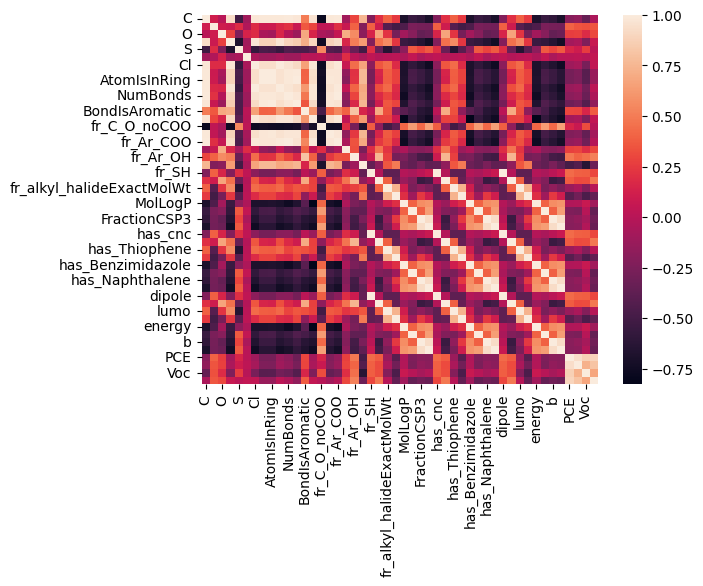

In [60]:
sns.heatmap(df.corr(), annot=False)

In [20]:
selected_targets = targets[ignore_samples_mask]
selected_features = features[ignore_samples_mask]
y_scaler = StandardScaler(with_std=True, with_mean=True, copy=True)
x_scaler = StandardScaler(with_std=True, with_mean=True, copy=True)
scaled_targets = y_scaler.fit_transform(selected_targets)
scaled_features = x_scaler.fit_transform(selected_features)

In [29]:
# For validation, use a KFold() split.
kf = KFold(n_splits=10, random_state=None, shuffle=True)
split_indices = kf.split(X=scaled_features)

print("Fitting model to data...")

for train_index, test_index in split_indices:
    ytrain = scaled_targets[train_index]
    ytest = scaled_targets[test_index]
    xtrain = scaled_features[train_index]
    xtest = scaled_features[test_index]

    # model = LinearRegression().fit(xtrain, ytrain)
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)

    model.fit(xtrain, ytrain)

    predicted = model.predict(xtest)
    predicted = y_scaler.inverse_transform(predicted)
    test_labels_rescaled = y_scaler.inverse_transform(ytest)
    print("R2 score: ", r2_score(test_labels_rescaled, predicted))

Fitting model to data...
R2 score:  0.3765673938881091
R2 score:  0.3559614023924944
R2 score:  -0.2059919181206108
R2 score:  0.5816741373927641
R2 score:  0.48989952393265945
R2 score:  0.6884228243026341
R2 score:  0.47317911082395514
R2 score:  0.3261228122532551
R2 score:  0.5252184077734425
R2 score:  -0.030639454928538618
